# Face Swap Training
Train a model to swap any face to a target identity from your custom dataset.

Based on the approach from "Fast Face-swap Using Convolutional Neural Networks" (Korshunova et al., ICCV 2017)

# Dataset

In [46]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from facenet_pytorch import MTCNN

print("CUDA available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

CUDA available: True


In [47]:
# Configuration cell - UPDATE THESE VALUES

# Configuration
IMAGE_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 200  # More epochs
LR = 1e-4

# Choose target identity class
TARGET_CLASS = "Andrew"

# Paths
CUSTOM_DATASET_PATH = "../data/Face-Swap-M2-Dataset/dataset/smaller"
CELEBA_PATH = "C:/Users/Arthur/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba"

# INCREASE training data significantly
NUM_CELEBA_IMAGES = 2000  # Was 50, now 2000

In [48]:
# Load target identity images (style images)
def load_target_images(dataset_path, target_class, image_size):
    """Load all images from the target class folder."""
    target_dir = os.path.join(dataset_path, target_class)
    images = []
    
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1]
    ])
    
    for fname in os.listdir(target_dir):
        fpath = os.path.join(target_dir, fname)
        try:
            img = Image.open(fpath).convert('RGB')
            img_tensor = transform(img)
            images.append(img_tensor)
        except Exception as e:
            print(f"Error loading {fpath}: {e}")
            continue
    
    print(f"Loaded {len(images)} images for target class '{target_class}'")
    return torch.stack(images)

target_images = load_target_images(CUSTOM_DATASET_PATH, TARGET_CLASS, IMAGE_SIZE)
target_images = target_images.to(device)
print(f"Target images shape: {target_images.shape}")

Loaded 11 images for target class 'Andrew'
Target images shape: torch.Size([11, 3, 256, 256])


In [49]:
# CelebA Dataset for content images
class CelebADataset(Dataset):
    def __init__(self, celeba_path, num_images, image_size):
        self.celeba_path = celeba_path
        self.image_size = image_size
        
        # Get all image files and sample
        all_files = sorted([f for f in os.listdir(celeba_path) if f.endswith('.jpg')])
        self.files = random.sample(all_files, min(num_images, len(all_files)))
        
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        print(f"CelebA dataset: {len(self.files)} images")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.celeba_path, self.files[idx])
        img = Image.open(img_path).convert('RGB')
        return self.transform(img)

celeba_dataset = CelebADataset(CELEBA_PATH, NUM_CELEBA_IMAGES, IMAGE_SIZE)
celeba_loader = DataLoader(celeba_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

CelebA dataset: 2000 images


# Model Architecture

The Transformation Network transforms any input face to look like the target identity.
Based on the multiscale architecture from Korshunova et al.

In [50]:
class ResidualBlock(nn.Module):
    """Residual block with two conv layers."""
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.InstanceNorm2d(channels)
        )
    
    def forward(self, x):
        return x + self.block(x)


class TransformationNetwork(nn.Module):
    """
    Multiscale transformation network for face swapping.
    Takes an input face and transforms it to look like the target identity.
    """
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        # Residual blocks
        self.residual = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 3, 7, padding=3),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.residual(x)
        x = self.decoder(x)
        return x


# VGG for perceptual loss
class VGGFeatures(nn.Module):
    """Extract features from VGG19 for perceptual loss."""
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        
        # Normalize input from [-1, 1] to VGG expected range
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
        
        # Extract features at different layers
        self.slice1 = nn.Sequential(*list(vgg.children())[:4])   # relu1_2
        self.slice2 = nn.Sequential(*list(vgg.children())[4:9])  # relu2_2
        self.slice3 = nn.Sequential(*list(vgg.children())[9:18]) # relu3_4
        self.slice4 = nn.Sequential(*list(vgg.children())[18:27]) # relu4_4
        
        for param in self.parameters():
            param.requires_grad = False
    
    def normalize(self, x):
        # Convert from [-1, 1] to [0, 1], then normalize for VGG
        x = (x + 1) / 2
        return (x - self.mean) / self.std
    
    def forward(self, x):
        x = self.normalize(x)
        h1 = self.slice1(x)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)
        h4 = self.slice4(h3)
        return [h1, h2, h3, h4]


print("Models defined")

Models defined


# Loss Functions

- **Content Loss**: Preserves pose and expression from input
- **Style Loss**: Matches identity features from target images using patch-based matching
- **Identity Loss**: Uses a face recognition network to match target identity

In [51]:
# Cell: Loss Functions - REPLACE ENTIRELY

from facenet_pytorch import InceptionResnetV1

class FaceSwapLoss(nn.Module):
    """
    Combined loss for face swapping:
    - Content loss: preserve pose/expression from input (VGG deep layers)
    - Style loss: texture matching via Gram matrices
    - Identity loss: face recognition embedding matching (most important for identity!)
    - TV loss: spatial smoothness
    """
    def __init__(self, target_images, content_weight=1.0, style_weight=1e3, 
                 identity_weight=5.0, tv_weight=1e-6):
        super().__init__()
        self.vgg = VGGFeatures().to(device)
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.identity_weight = identity_weight
        self.tv_weight = tv_weight
        
        # Face recognition network for identity loss
        print("Loading FaceNet for identity loss...")
        self.facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
        for param in self.facenet.parameters():
            param.requires_grad = False
        
        # Pre-compute target identity embedding (averaged)
        print("Computing target identity embedding...")
        with torch.no_grad():
            # FaceNet expects [0, 1] range and 160x160
            target_resized = F.interpolate(target_images, size=(160, 160), mode='bilinear', align_corners=False)
            target_normalized = (target_resized + 1) / 2  # [-1,1] -> [0,1]
            target_embeddings = self.facenet(target_normalized)
            self.target_embedding = target_embeddings.mean(dim=0, keepdim=True)
            print(f"  Target embedding shape: {self.target_embedding.shape}")
        
        # Pre-compute target Gram matrices for style loss
        print("Pre-computing target style features...")
        with torch.no_grad():
            target_feats = self.vgg(target_images)
            self.target_grams = []
            for layer_idx in [0, 1]:  # Only shallow layers for texture
                gram = self.gram_matrix(target_feats[layer_idx])
                avg_gram = gram.mean(dim=0, keepdim=True)
                self.target_grams.append(avg_gram)
                print(f"  Layer {layer_idx}: Gram mean={avg_gram.mean().item():.4f}")
        print("Target features computed!")
    
    def gram_matrix(self, x):
        b, c, h, w = x.size()
        features = x.view(b, c, h * w)
        gram = torch.bmm(features, features.transpose(1, 2))
        return gram / (h * w)
    
    def content_loss(self, output_features, input_features):
        """Preserve pose/expression using deep VGG layers."""
        loss = 0
        # relu3_4 and relu4_4 for content
        for out_feat, in_feat in zip(output_features[2:], input_features[2:]):
            loss += F.mse_loss(out_feat, in_feat)
        return loss
    
    def style_loss(self, output_features):
        """Gram-matrix style loss for texture."""
        loss = 0
        for layer_idx in [0, 1]:
            out_gram = self.gram_matrix(output_features[layer_idx])
            target_gram = self.target_grams[layer_idx].expand(out_gram.size(0), -1, -1)
            loss += F.l1_loss(out_gram, target_gram)
        return loss
    
    def identity_loss(self, output):
        """Match face identity using FaceNet embeddings."""
        # Resize and normalize for FaceNet
        output_resized = F.interpolate(output, size=(160, 160), mode='bilinear', align_corners=False)
        output_normalized = (output_resized + 1) / 2  # [-1,1] -> [0,1]
        
        output_embedding = self.facenet(output_normalized)
        target_embedding = self.target_embedding.expand(output_embedding.size(0), -1)
        
        # Cosine similarity loss (1 - similarity)
        cos_sim = F.cosine_similarity(output_embedding, target_embedding)
        return (1 - cos_sim).mean()
    
    def tv_loss(self, x):
        diff_h = x[:, :, 1:, :] - x[:, :, :-1, :]
        diff_w = x[:, :, :, 1:] - x[:, :, :, :-1]
        return diff_h.abs().mean() + diff_w.abs().mean()
    
    def forward(self, output, input_img):
        output_features = self.vgg(output)
        input_features = self.vgg(input_img)
        
        c_loss = self.content_loss(output_features, input_features)
        s_loss = self.style_loss(output_features)
        id_loss = self.identity_loss(output)
        tv_loss = self.tv_loss(output)
        
        total_loss = (self.content_weight * c_loss + 
                      self.style_weight * s_loss + 
                      self.identity_weight * id_loss +
                      self.tv_weight * tv_loss)
        
        return total_loss, c_loss.item(), s_loss.item(), id_loss.item()


print("Loss functions defined")

Loss functions defined


# Initialize Model and Training

In [52]:
# Initialize Model cell - UPDATE WEIGHTS

# Initialize model
model = TransformationNetwork().to(device)

# REBALANCED loss weights - identity is now dominant
criterion = FaceSwapLoss(
    target_images=target_images,
    content_weight=1.0,       # Keep pose/expression
    style_weight=100.0,       # Reduced from 1e3 (texture less important)
    identity_weight=50.0,     # INCREASED from 5.0 - now the main driver!
    tv_weight=1e-6
)

# Optimizer with lower learning rate for stability
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Transformation Network has {num_params:,} trainable parameters")

Loading FaceNet for identity loss...
Computing target identity embedding...
  Target embedding shape: torch.Size([1, 512])
Pre-computing target style features...
  Layer 0: Gram mean=0.1690
  Layer 1: Gram mean=0.3649
Target features computed!
Transformation Network has 7,837,699 trainable parameters


# Training Loop

In [53]:
# Training Loop cell - REPLACE ENTIRELY

import time

def train_epoch(model, dataloader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    content_losses = 0
    style_losses = 0
    identity_losses = 0  # Changed from tv_losses
    
    start_time = time.time()
    
    for batch_idx, content_imgs in enumerate(dataloader):
        content_imgs = content_imgs.to(device)
        
        # Forward pass
        output = model(content_imgs)
        
        # Compute loss - now returns (total, content, style, identity)
        loss, c_loss, s_loss, id_loss = criterion(output, content_imgs)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        content_losses += c_loss
        style_losses += s_loss
        identity_losses += id_loss  # Changed
        
        if (batch_idx + 1) % 50 == 0:
            elapsed = time.time() - start_time
            print(f"  Batch {batch_idx+1}/{len(dataloader)} - "
                  f"Loss: {loss.item():.4f} (C:{c_loss:.4f}, S:{s_loss:.4f}, ID:{id_loss:.4f}) - "
                  f"Time: {elapsed:.1f}s")
    
    n_batches = len(dataloader)
    return {
        'total': total_loss / n_batches,
        'content': content_losses / n_batches,
        'style': style_losses / n_batches,
        'identity': identity_losses / n_batches  # Changed from 'tv'
    }


def visualize_results(model, dataloader, target_images, num_samples=4):
    """Visualize face swap results."""
    model.eval()
    
    # Get a batch of content images
    content_imgs = next(iter(dataloader))[:num_samples].to(device)
    
    with torch.no_grad():
        output = model(content_imgs)
    
    # Denormalize for display
    def denorm(x):
        return (x + 1) / 2
    
    fig, axes = plt.subplots(3, num_samples, figsize=(4 * num_samples, 12))
    
    for i in range(num_samples):
        # Input face
        axes[0, i].imshow(denorm(content_imgs[i]).cpu().permute(1, 2, 0).clamp(0, 1))
        axes[0, i].set_title("Input")
        axes[0, i].axis('off')
        
        # Output (swapped face)
        axes[1, i].imshow(denorm(output[i]).cpu().permute(1, 2, 0).clamp(0, 1))
        axes[1, i].set_title("Swapped")
        axes[1, i].axis('off')
        
        # Target identity (reference)
        target_idx = i % target_images.size(0)
        axes[2, i].imshow(denorm(target_images[target_idx]).cpu().permute(1, 2, 0).clamp(0, 1))
        axes[2, i].set_title("Target Identity")
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    model.train()


print("Training functions defined")

Training functions defined


In [54]:
# Training cell - reset history with correct keys

# Training
history = {'total': [], 'content': [], 'style': [], 'identity': []}

EPOCHS = 50

print(f"Training face swap model for {EPOCHS} epochs...")
print(f"Target identity: {TARGET_CLASS}")
print(f"Training on {len(celeba_dataset)} CelebA images")
print("-" * 60)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    losses = train_epoch(model, celeba_loader, criterion, optimizer, epoch)
    scheduler.step()
    
    for key in history:
        history[key].append(losses[key])
    
    print(f"  Total Loss: {losses['total']:.4f} | "
          f"Content: {losses['content']:.4f} | "
          f"Style: {losses['style']:.4f} | "
          f"Identity: {losses['identity']:.4f}")
    
    # Visualize every 10 epochs
    if (epoch + 1) % 10 == 0:
        visualize_results(model, celeba_loader, target_images)
    
    # Save checkpoint every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint_path = f"models/faceswap_{TARGET_CLASS}_epoch{epoch+1}.pth"
        os.makedirs("models", exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses['total'],
        }, checkpoint_path)
        print(f"  Saved checkpoint: {checkpoint_path}")

print("\nTraining complete!")

Training face swap model for 50 epochs...
Target identity: Andrew
Training on 2000 CelebA images
------------------------------------------------------------

Epoch 1/50
  Batch 50/250 - Loss: 71.2280 (C:13.4253, S:0.2952, ID:0.5657) - Time: 62.3s
  Batch 100/250 - Loss: 65.5657 (C:12.3619, S:0.2484, ID:0.5672) - Time: 124.5s
  Batch 150/250 - Loss: 65.3556 (C:13.5244, S:0.2148, ID:0.6070) - Time: 186.9s
  Batch 200/250 - Loss: 53.8142 (C:12.6328, S:0.1732, ID:0.4773) - Time: 248.9s
  Batch 250/250 - Loss: 49.0320 (C:12.3716, S:0.1494, ID:0.4343) - Time: 311.1s
  Total Loss: 65.9626 | Content: 13.2996 | Style: 0.2579 | Identity: 0.5375

Epoch 2/50
  Batch 50/250 - Loss: 45.3388 (C:11.0629, S:0.1317, ID:0.4221) - Time: 58.8s
  Batch 100/250 - Loss: 43.2365 (C:12.8139, S:0.1290, ID:0.3504) - Time: 118.1s
  Batch 150/250 - Loss: 44.1893 (C:11.7261, S:0.1278, ID:0.3937) - Time: 178.0s
  Batch 200/250 - Loss: 41.1473 (C:10.6613, S:0.1281, ID:0.3536) - Time: 238.0s
  Batch 250/250 - Loss: 38

KeyboardInterrupt: 

# Plot Training History

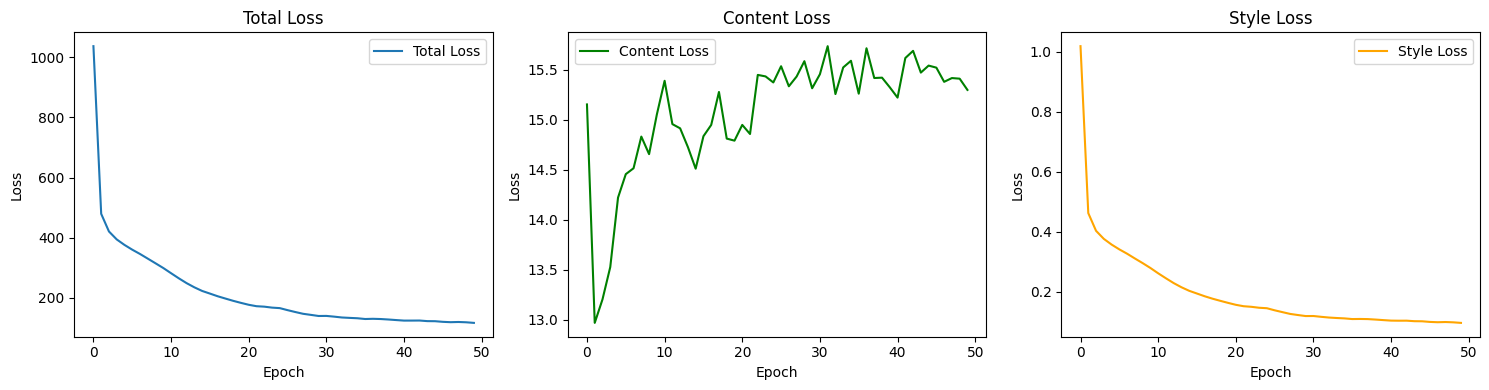

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['total'], label='Total Loss')
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history['content'], label='Content Loss', color='green')
axes[1].set_title('Content Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(history['style'], label='Style Loss', color='orange')
axes[2].set_title('Style Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()
plt.show()

# Final Results and Testing

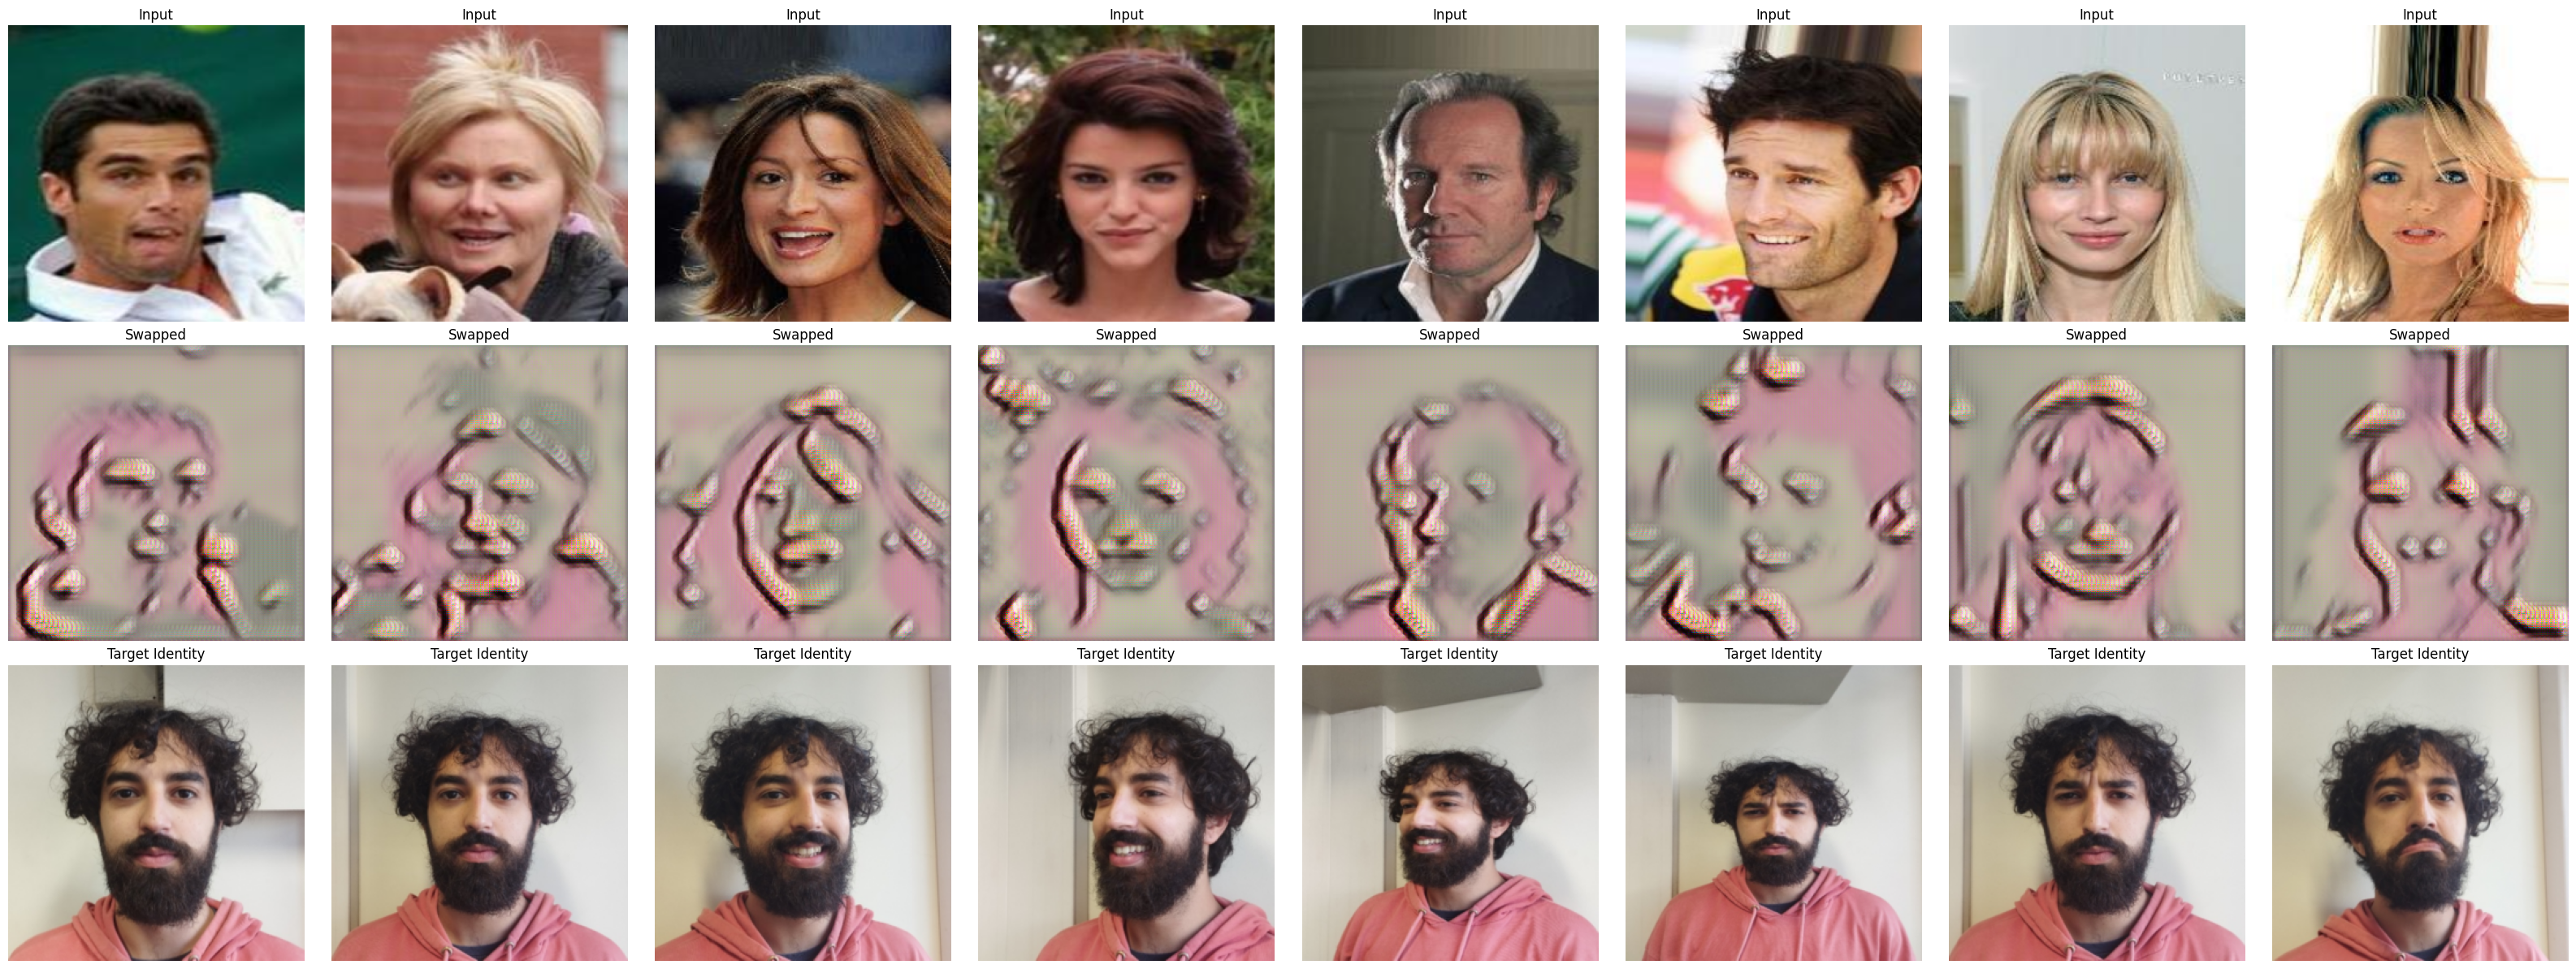

In [ ]:
# Final visualization with more samples
visualize_results(model, celeba_loader, target_images, num_samples=8)

In [ ]:
# Test on a specific image
def swap_single_image(model, image_path, image_size=256):
    """Apply face swap to a single image."""
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
    
    # Denormalize
    def denorm(x):
        return (x + 1) / 2
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(denorm(img_tensor[0]).cpu().permute(1, 2, 0).clamp(0, 1))
    axes[0].set_title("Input")
    axes[0].axis('off')
    
    axes[1].imshow(denorm(output[0]).cpu().permute(1, 2, 0).clamp(0, 1))
    axes[1].set_title(f"Swapped to {TARGET_CLASS}")
    axes[1].axis('off')
    
    axes[2].imshow(denorm(target_images[0]).cpu().permute(1, 2, 0).clamp(0, 1))
    axes[2].set_title("Target Identity")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return output

# Example: swap a random CelebA image
sample_img_path = os.path.join(CELEBA_PATH, celeba_dataset.files[100])
swap_single_image(model, sample_img_path)

IndexError: list index out of range

In [ ]:
# Save final model
final_model_path = f"models/faceswap_{TARGET_CLASS}_final.pth"
os.makedirs("models", exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(),
    'target_class': TARGET_CLASS,
    'image_size': IMAGE_SIZE,
    'history': history
}, final_model_path)
print(f"Final model saved to: {final_model_path}")

# Load and Use a Trained Model
Run this section to load a previously trained model and apply face swaps.

In [ ]:
# Load a trained model (uncomment and modify path as needed)
# def load_model(model_path):
#     checkpoint = torch.load(model_path)
#     model = TransformationNetwork().to(device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
#     print(f"Loaded model for target class: {checkpoint.get('target_class', 'unknown')}")
#     return model
# 
# # Example usage:
# # loaded_model = load_model("models/faceswap_arthur_final.pth")
# # swap_single_image(loaded_model, "path/to/your/image.jpg")